<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/BarCodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Subí una imagen (png/jpg)…


Saving conaprole.png to conaprole.png


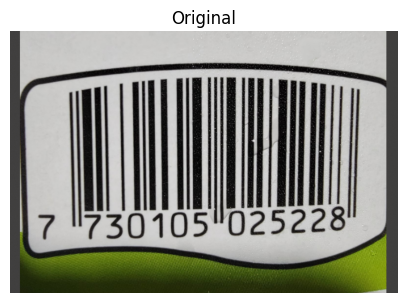

=== Método A (pyzbar) ===
- Tipo: EAN13, Data: 7730105025228, Rect: (108, 113, 523, 208)


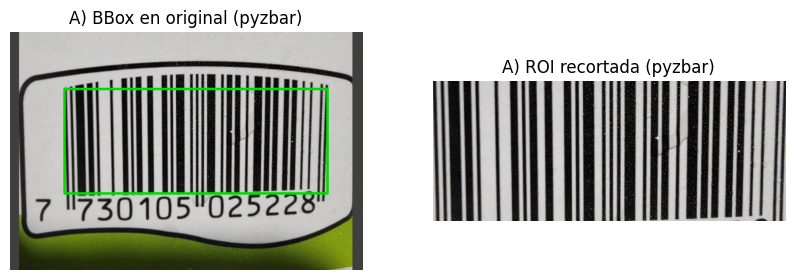


=== Método B (OpenCV morfológico) ===
BBox: (x=2, y=37, w=698, h=112)


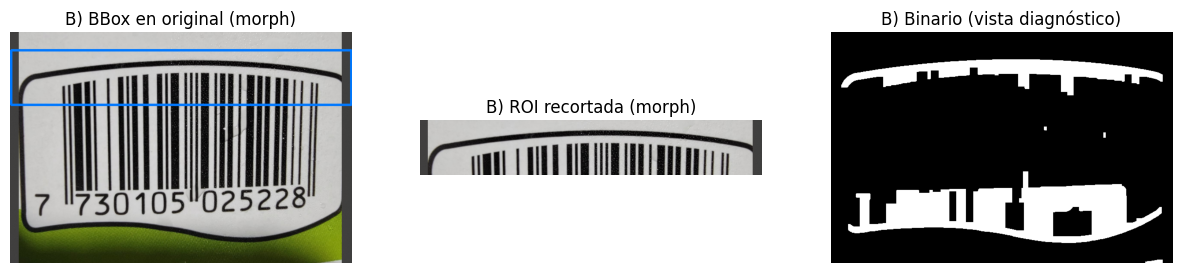


Resultado: Ambos métodos detectaron ROI. Sugerencia: usar A) pyzbar (área A=108784, B=78176).


In [3]:
# =========================
# 1) Instalación y imports
# =========================
!apt-get -y -qq install libzbar0 >/dev/null
!pip -q install pyzbar opencv-python numpy matplotlib >/dev/null

import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from pyzbar.pyzbar import decode

# Utilidad: mostrar imágenes lado a lado
def show_images(titles_imgs, cmap=None):
    n = len(titles_imgs)
    plt.figure(figsize=(5*n, 5))
    for i, (title, img) in enumerate(titles_imgs, 1):
        plt.subplot(1, n, i)
        if img is None:
            plt.title(f"{title}\n(None)")
            plt.axis("off")
            continue
        if img.ndim == 2:
            plt.imshow(img, cmap=cmap or "gray")
        else:
            # BGR -> RGB
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    plt.show()

# ============================================
# 2) Cargar imagen (subí un archivo desde PC)
# ============================================
print("Subí una imagen (png/jpg)…")
up = files.upload()
assert len(up) > 0, "No se subió imagen."
name, content = next(iter(up.items()))
data = np.frombuffer(content, dtype=np.uint8)
img_bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
assert img_bgr is not None, "No se pudo leer la imagen."

show_images([("Original", img_bgr)])

# ==============================================
# 3) Método A — pyzbar (detecta y decodifica)
#    Devuelve bbox del barcode si puede leerlo
# ==============================================
def crop_barcode_pyzbar(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    results = decode(gray)
    if not results:
        return None, None, []
    # tomar el de mayor área
    r = max(results, key=lambda z: z.rect.width * z.rect.height)
    x, y, w, h = r.rect.left, r.rect.top, r.rect.width, r.rect.height
    x0, y0, x1, y1 = max(0,x), max(0,y), min(x+w, img_bgr.shape[1]), min(y+h, img_bgr.shape[0])
    roi = img_bgr[y0:y1, x0:x1].copy()

    # Decodificaciones disponibles
    decoded = []
    for z in results:
        try:
            decoded.append({
                "type": z.type,
                "data": z.data.decode("utf-8", errors="ignore"),
                "rect": (z.rect.left, z.rect.top, z.rect.width, z.rect.height)
            })
        except Exception:
            decoded.append({
                "type": z.type,
                "data": str(z.data),
                "rect": (z.rect.left, z.rect.top, z.rect.width, z.rect.height)
            })
    return roi, (x0, y0, x1-x0, y1-y0), decoded

roiA, boxA, decodedA = crop_barcode_pyzbar(img_bgr)

visA = img_bgr.copy()
if boxA is not None:
    x, y, w, h = boxA
    cv2.rectangle(visA, (x, y), (x+w, y+h), (0, 220, 0), 3)

print("=== Método A (pyzbar) ===")
if decodedA:
    for d in decodedA:
        print(f"- Tipo: {d['type']}, Data: {d['data']}, Rect: {d['rect']}")
else:
    print("No se decodificó ningún código (puede estar muy borroso o no soportado).")

show_images([
    ("A) BBox en original (pyzbar)", visA),
    ("A) ROI recortada (pyzbar)", roiA if roiA is not None else np.zeros((10,10,3), np.uint8))
])

# =========================================================
# 4) Método B — OpenCV (morfología + gradiente) sin decode
#    Prueba orientación horizontal y vertical, elige mejor
# =========================================================
def morph_best_bbox(gray):
    # Utilidad: evaluar una dirección (dx, dy) y kernel
    def eval_dir(dx, dy, kx, ky):
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=dx, dy=dy, ksize=3)
        grad = cv2.convertScaleAbs(grad)
        grad = cv2.normalize(grad, None, 0, 255, cv2.NORM_MINMAX)
        _, th = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kx, ky))
        closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
        closed = cv2.erode(closed, None, iterations=2)
        closed = cv2.dilate(closed, None, iterations=2)
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            return None, None
        # score por área y razón de aspecto (típicamente alargado)
        best, best_score = None, -1
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            area = w*h
            aspect = max(w, h) / (min(w, h) + 1e-6)
            score = area * (aspect if aspect > 1.5 else 0.3)
            if score > best_score:
                best_score, best = score, (x, y, w, h, closed)
        return best, best_score

    # Probar ambas orientaciones
    bx1, sc1 = eval_dir(1, 0, 25, 7)   # barras verticales (gradiente X)
    bx2, sc2 = eval_dir(0, 1, 7, 25)   # barras horizontales (gradiente Y)

    if bx1 is None and bx2 is None:
        return None, None
    if sc2 is None or (sc1 is not None and sc1 >= sc2):
        x, y, w, h, binimg = bx1
    else:
        x, y, w, h, binimg = bx2
    return (x, y, w, h), binimg

def crop_barcode_morph(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    best, binimg = morph_best_bbox(gray)
    if best is None:
        return None, None, None
    x, y, w, h = best

    # pad leve para no cortar barras
    pad = int(0.03 * max(w, h))
    x2 = max(x - pad, 0)
    y2 = max(y - pad, 0)
    x3 = min(x + w + pad, img_bgr.shape[1])
    y3 = min(y + h + pad, img_bgr.shape[0])

    roi = img_bgr[y2:y3, x2:x3].copy()
    return roi, (x2, y2, x3-x2, y3-y2), binimg

roiB, boxB, binB = crop_barcode_morph(img_bgr)

visB = img_bgr.copy()
if boxB is not None:
    x, y, w, h = boxB
    cv2.rectangle(visB, (x, y), (x+w, y+h), (255, 120, 0), 3)

print("\n=== Método B (OpenCV morfológico) ===")
if boxB is not None:
    print(f"BBox: (x={x}, y={y}, w={w}, h={h})")
else:
    print("No se detectó región con patrón de barras.")

show_images([
    ("B) BBox en original (morph)", visB),
    ("B) ROI recortada (morph)", roiB if roiB is not None else np.zeros((10,10,3), np.uint8)),
    ("B) Binario (vista diagnóstico)", binB if binB is not None else np.zeros((10,10), np.uint8))
], cmap="gray")

# ======================================================
# 5) Resumen rápido y elección sugerida (si ambos dan)
# ======================================================
if roiA is None and roiB is None:
    print("\nResultado: Ningún método encontró el código de barras.")
elif roiA is not None and roiB is None:
    print("\nResultado: Usar ROI de A) pyzbar (decodificó/detectó).")
elif roiA is None and roiB is not None:
    print("\nResultado: Usar ROI de B) morfología (no requiere decodificar).")
else:
    # si ambos existen, elegir el de mayor área (heurística simple)
    areaA = roiA.shape[0] * roiA.shape[1]
    areaB = roiB.shape[0] * roiB.shape[1]
    choice = "A) pyzbar" if areaA >= areaB else "B) morfología"
    print(f"\nResultado: Ambos métodos detectaron ROI. Sugerencia: usar {choice} (área A={areaA}, B={areaB}).")
